# TP MNIST PyTorch
Dans ce TP, vous allez entraîner un MLP à reconnaître des chiffres manuscrits en utilisant la base de données MNIST et la bibliothèque PyTorch. 

## Configuration
### Si vous utilisez un ordinateur de l'Enseirb:
#### 1) Lancer une session linux (et non pas windows)
#### 2) Aller dans "Applications", puis "Autre", puis "conda_pytorch" (un terminal devrait s'ouvrir)
#### 3) Dans ce terminal, taper la commande suivante pour lancer Spyder :  
`spyder &`  
### Si vous utilisez votre ordinateur personnel, il faudra installer Spyder.  

---
---
## Dans tous les cas, ne pas oublier de configurer Spyder en suivant ces [instructions](https://gbourmaud.github.io/files/configuration_spyder_annotated.pdf).
---
---

# I) Préparation de la base de données étiquetées MNIST

La base de données de reconnaissance de chiffres manuscrits MNIST est constituée d'environ 70 000 imagettes, chacune de taille 28x28.  
  
Il s'agit d'une **petite** base de données permettant de faire des apprentissages **en quelques secondes sur CPU**.  
  
Remarquons qu'il n'y aucun problème pour charger **toute** la base de données en mémoire (70 000 x 28 x 28 valeurs stockées sur 32 bits occupent environ 220 Mo). Il est très rare de se retrouver dans une telle situation, en général la base de données est **trop importante pour être chargée intégralement en mémoire** et il faut être capable de gérer le chargement des données depuis le disque dur **à la demande**.
  
L'objectif de ce TP étant de maîtriser les principaux outils permettant d'effectuer l'apprentissage d'un réseau de neurones, **nous allons voir comment effectuer ces chargements à la demande**. **Pour se rapprocher le plus possible d'un cas "classique" de chargement à la demande**, la base de données MNIST a été réorganisée en créant un fichier `.bmp` par image (donc 70 000 fichiers au total).  
  
Il va donc falloir prendre quelques précautions, en téléchargeant la base de données, pour que ces 70 000 fichiers soient créés en local sur le disque dur (par exemple en travaillant dans `/tmp`) et non pas à distance sur le serveur de l'Enseirb. **Rappel : votre répertoire "home" `~` se situe sur un serveur `/net/...`.** Si vous décompressiez l'archive dans votre "home", vous créeriez 70 000 fichiers sur le serveur ! Et chaque accès à un fichier entraînerait un transfert sur le réseau, ce qui serait très inefficace.

- Télécharger l'archive de la base de données dans `/tmp` : `wget -P /tmp https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/MNIST/MNIST.tar.gz`
- Décompresser l'archive dans `/tmp` : `tar -xzf /tmp/MNIST.tar.gz -C /tmp`
- Inspecter les fichiers décompressés. Combien y-a-t-il de données d'entraînement ? de données de test ? Visualiser plusieurs images.

# II) Chargement des données

Rappelons qu'en pratique :
* Un apprentissage se fait sur un (ou plusieurs) GPU. Remarque : dans ce TP nous utilisons MNIST qui est une base de données suffisamment petite pour faire des apprentissages sur CPU en quelques secondes. **Mais grâce à PyTorch, le code final pourra également s'exécuter sur GPU de manière transparente, comme nous allons le voir.**
* En général un apprentissage est long, donc on veut enchaîner les itérations de descente de gradient stochastique **sans perdre de temps à attendre qu'un minibatch soit chargé en mémoire depuis le disque dur**.
  
La solution consiste à laisser tourner des processus en tâche de fond **qui préparent des minibatches**. Lorsque la boucle d'apprentissage a fini une itération, elle récupère un minibatch qui est déjà prêt. S'il y a **suffisamment de processus tournant en tâche de fond** alors il y a toujours des minibatches disponibles et ainsi il n'y a pas de temps perdu où la boucle d'apprentissage attend que des données soient chargées depuis le disque dur.  
  
La bibliothèque PyTorch contient des fonctionnalités permettant d'obtenir un tel résultat, notamment à travers les classes `torch.utils.data.Dataset` et `torch.utils.data.Dataloader`. 


## 1) La classe `torch.utils.data.Dataset`

Dans un premier temps, il faut créer une classe `MNISTDataset` dédiée à la base de données MNIST qui hérite de `torch.utils.data.Dataset`.  La documentation de cette classe est consultable [ici](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

Cette classe `MNISTDataset` doit contenir au moins : 
- la méthode `def __init__(self, ...):` qui s'exécute à la création de l'objet. Cette méthode a principalement pour objectif de charger en mémoire la liste des noms des images de la base de données. Attention, il ne faut surtout pas charger toutes les images de la base de données dans cette fonction. Certes cela rentrerait en mémoire pour MNIST car cette base de données est *petite* mais cela ne fonctionnerait pas pour une base de données plus grande. Le chargement d'une image s'effectue dans la méthode `def __getitem__(self, idx):`.
- la méthode `def __len__(self):` qui renvoie le nombre de données étiquetées de la base
- la méthode `def __getitem__(self, idx):` qui permet de charger et de renvoyer l'image numéro `idx` ainsi que son étiquette et toutes les autres informations jugées nécessaires.

Pour gagner du temps, les étapes précédents ont déjà été implémentées : [MNISTDataset.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/MNIST/MNISTDataset.py)

Dans un nouveau script `main.py`, tester ce `Dataset` en affichant 4 éléments de la base de données MNIST.

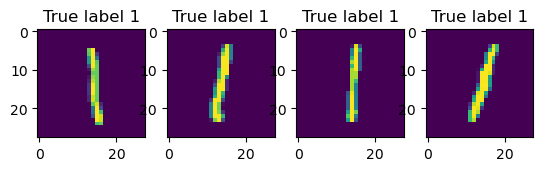

In [1]:
import torch
from MNISTDataset import MNISTDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn

torch.random.manual_seed(0)
path_MNIST_train = '/tmp/MNIST/Training'
mean_norm = 0. #0.1306
std_norm = 1. #0.3081            
training_set = MNISTDataset(path_MNIST_train, mean_norm=mean_norm, std_norm=std_norm)

#%% Show 4 pairs of data
fig1, axs1 = plt.subplots(ncols=4)

offset = 7000
for i in range(4):
    image, label, _ = training_set[i+offset]
    axs1[i].imshow(T.ToPILImage()((image*std_norm)+mean_norm))
    axs1[i].set_title('True label {}'.format(label))
    
plt.pause(1.)

### Normalisation des données

En pratique, les données doivent être normalisées pour faciliter l'apprentissage. La normalisation s'effectue généralement en calculant la moyenne empirique et l'écart-type empirique de la base de données.


In [2]:
#%% Compute mean and std
mean = 0
data_full = []
for i in range(len(training_set)):
    if(i%10000==0):
        print(i)
    image, label, _ = training_set[i]
    data_full.append(image.ravel().data) #stores all data, only possible because MNIST is small
    
data_full_concat = torch.cat(data_full)
mean = torch.mean(data_full_concat)
std = torch.std(data_full_concat)
print('Mean MNIST {}, Std MNIST {}'.format(mean, std))

0
10000
20000
30000
40000
50000
Mean MNIST 0.13059155642986298, Std MNIST 0.30801624059677124


Vous pouvez utiliser ces valeurs lorsque vous créez un object MNISTDataset : `training_set = MNISTDataset(path_MNIST_train, mean_norm=0.1306, std_norm=0.3080)`

## 2) La classe `torch.utils.data.DataLoader`


Maintenant que le `Dataset` fonctionne, il suffit de l'utiliser lors de la création d'un `DataLoader` pour que PyTorch se charge de créer des processus qui vont préparer des minibatches en tâche de fond.

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = training_set,
                                       batch_size=batch_size, #nombre d'éléments d'un minibatch
                                       shuffle=True, #mélanger la base de données à la fin de chaque epoch
                                       num_workers=2) #nombre de processus dédiées à la préparation des minibatches

Afficher les 10 premiers éléments du premier minibatch.

In [ ]:
images, labels, _ = next(iter(train_loader))

# Show 10 pairs of data
fig2, axs2 = plt.subplots(ncols=10)
for i in range(10):
    axs2[i].imshow(T.ToPILImage()((images[i,:,:,:]*std_norm)+mean_norm))
    axs2[i].set_title('{}'.format(labels[i]))
    
plt.pause(1.)

- Quelle est la taille du tenseur `images` (`images.shape`) ?  En PyTorch, un minibatch d'images est un tenseur 4D : `taille_minibatch x nombre_de_canaux x nombre_de_lignes x nombre_de_colonnes`. 
- Quelle est la taille du tenseur `labels` ?

Afin d'implémenter un entraînement avec arrêt prématuré, il nous faut également un dataloader de validation.

In [ ]:
path_MNIST_valid = '/tmp/MNIST/Validation'                
valid_set = MNISTDataset(path_MNIST_valid)
valid_loader = torch.utils.data.DataLoader(dataset = valid_set,
                                       batch_size=batch_size,
                                       shuffle=False,#inutile de mélanger pour la validation
                                       num_workers=2)

# IV) MLP sur MNIST


Maintenant que le `DataLoader` de MNIST est prêt, vous pouvez reprendre et adapter le code du MLP obtenu à la fin du `TP MLP PyTorch jouet` [main_MLP_two_layers_pytorch_with_optim.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/misc/main_MLP_two_layers_pytorch_with_optim.py) (avec le fichier [utils.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/misc/utils.py)) afin de lancer un apprentissage sur la base de données MNIST.

#### 0) Attention, le dataloader ressort des tenseurs de taille `taille_minibatch x nombre_de_canaux x nombre_de_lignes x nombre_de_colonnes` alors qu'un MLP fonctionne sur un minibatch de vecteurs : `taille_minibatch x taille_vecteur`. Vous pouvez vectoriser les 3 dernières dimensions d'un tenseur de taille `Mx1x28x28` (dans le but d'obtenir un tenseur de taille `Mx784`) en utilisant la méthode `.view(-1, 784)`.
#### 1) Séparer l'architecture du code d'entraînement en mettant la définition de la classe `MLP` dans un fichier `MLP.py`.
#### 2) Lancer un apprentissage sur un seul minibatch pour vous assurer que le coût atteint rapidement (presque) zéro, ce qui permet d'évacuer beaucoup de bugs présents dans votre code.
#### 3) Implémenter un arrêt prématuré en codant une fonction de validation permettant d'évaluer les performances du réseau à la fin de chaque epoch (utiliser `with torch.no_grad():` car nous n'avons pas besoin de calculer de gradient pendant la validation). Il faudra stocker les paramètres du réseau si les performances sont les meilleurs obtenues jusqu'à présent : `torch.save(model.state_dict(), './model.pt')`. Ajouter la courbe de validation aux affichages.
#### 4) Vous pouvez stopper l'apprentissage manuellement lorsque vous constatez qu'il n'y a plus d'amélioration des performances.
---

Si vous êtes bloqués, voici un exemple de correction : [main_MLP_MNIST_wo_tensorboard.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/MNIST/main_MLP_MNIST_wo_tensorboard.py) avec le fichier [MLP.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/MNIST/MLP.py)  

Après avoir effectué un apprentissage, vous pouvez tester votre modèle avec le code suivant : [main_test_model.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/MNIST/main_test_model.py)

Le code de correction atteint rapidement un taux de bonne classification de 95%. Il est possible de gagner encore quelques points en rajoutant des couches (actuellement le MLP n'a qu'une couche cachée), où encore en rajoutant une évolution du pas d'apprentissage comme [une réduction sur plateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html).

**Affichages**  
Le code de correction utilise Matplotlib pour réaliser les affichages. Nous allons désormais utiliser un outil dédié : **TensorBoard**.

# V) TensorBoard


TensorBoard est un outil de visualisation dédié aux expériences d'appentissage automatique. Il permet notamment de tracer des courbes au cours de l'entraînement ou encore de superposer des courbes issues de différents entraînement.
Un exemple d'utilisation est présenté ici : https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html

L'objectif de cette partie est d'utiliser cet outil, en rajoutant quelques lignes de code à votre code d'entraînement du MLP sur MNIST (essentiellement `from torch.utils.tensorboard import SummaryWriter
`, `writer = SummaryWriter()`, `writer.add_scalar(...)`)
 , pour afficher des informations relatives à l'entraînement en cours (courbe du coût d'apprentissage, courbe du coût de validation, courbe de la précision de validation, valeur du pas d'apprentissage au cours du temps, valeurs de certains gradients, etc.).

# VI) MNIST décentré


Les images de la base de données MNIST sont de taille 28x28. Dans chaque image, le chiffre se situe au centre de l'image. 

L'objectif de cette partie est de modifier le `Dataset` pour obtenir des images de taille 56x56 où le chiffre n'est plus centré. Ceci peut par exemple être implémenté dans la méthode `__get_item__` en générant une translation aléatoire (en x et en y) et en l'appliquant à l'image chargée.

Cette nouvelle base de donnée, qu'on appellera *MNISTTranslation*, correspond à un problème d'apprentissage supervisé plus difficile que le problème initial. Pourquoi ? 

Lancer un entraînement avec le MLP précédemment implémenté. Que constatez-vous ? Pourquoi ?